# 사전 학습된 CNN(VGG-16)을 이용한 Fine Tunig
## VGG-16 Model
* University of Oxford - Visual Geometry Group
* 2014 ILSVRC 2nd Model
* ImageNet Large Scale Visual Recognition Challenge (ILSVRC)


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!nvidia-smi

Thu Sep  2 05:03:29 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Import Tensorflow

In [ ]:
import tensorflow

tensorflow.__version__

'2.6.0'

# I. Google Drive Mount
* 'dogs_and_cats_small.zip' 디렉토리를 구글드라이브에 업로드

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


> ## 1) 구글 드라이브 마운트 결과 확인

In [ ]:
!ls -l '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'

-rw------- 1 root root 90618980 Mar  4 04:51 '/content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip'


> ## 2) unzip 'dogs_and_cats_small.zip'

In [ ]:
!unzip /content/drive/My\ Drive/Colab\ Notebooks/datasets/dogs_and_cats_small.zip

Archive:  /content/drive/My Drive/Colab Notebooks/datasets/dogs_and_cats_small.zip
  inflating: test/cats/cat.1501.jpg  
  inflating: test/cats/cat.1502.jpg  
  inflating: test/cats/cat.1503.jpg  
  inflating: test/cats/cat.1504.jpg  
  inflating: test/cats/cat.1505.jpg  
  inflating: test/cats/cat.1506.jpg  
  inflating: test/cats/cat.1507.jpg  
  inflating: test/cats/cat.1508.jpg  
  inflating: test/cats/cat.1509.jpg  
  inflating: test/cats/cat.1510.jpg  
  inflating: test/cats/cat.1511.jpg  
  inflating: test/cats/cat.1512.jpg  
  inflating: test/cats/cat.1513.jpg  
  inflating: test/cats/cat.1514.jpg  
  inflating: test/cats/cat.1515.jpg  
  inflating: test/cats/cat.1516.jpg  
  inflating: test/cats/cat.1517.jpg  
  inflating: test/cats/cat.1518.jpg  
  inflating: test/cats/cat.1519.jpg  
  inflating: test/cats/cat.1520.jpg  
  inflating: test/cats/cat.1521.jpg  
  inflating: test/cats/cat.1522.jpg  
  inflating: test/cats/cat.1523.jpg  
  inflating: test/cats/cat.1524.jpg  
  inf

In [ ]:
!ls -l

total 20
drwx------ 5 root root 4096 Sep  2 05:08 drive
drwxr-xr-x 1 root root 4096 Aug 31 13:18 sample_data
drwxr-xr-x 4 root root 4096 Sep  2 05:08 test
drwxr-xr-x 4 root root 4096 Sep  2 05:08 train
drwxr-xr-x 4 root root 4096 Sep  2 05:08 validation


# II. Image_File Directory Setting

* train_dir
* valid_dir
* test_dir

In [ ]:
train_dir = 'train'
valid_dir = 'validation'
test_dir = 'test'

# III. Data Preprocessing

> ## 1) ImageDataGenerator( ) & flow_from_directory( )

* Normalization
 * ImageDataGenerator( )
* Resizing & Generator
 * flow_from_directory( )

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255)
valid_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

valid_generator = valid_datagen.flow_from_directory(
                  valid_dir,
                  target_size = (150, 150),
                  batch_size = 20,
                  class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# IV. Import VGG-16 Model & Some Layers Freezing

> ## 1) conv_base

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape = (150, 150, 3))

58900480/58889256 [==============================] - 1s 0us/step


> ## 2) Model Information

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

> ## 3) 'block5_conv1' Freezing

* Before 'weight' Freezing

In [ ]:
print('conv_base 동결 전 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 전 훈련 가능 가중치의 종류: 26


* 'weight' Freezing

In [ ]:
set_trainable = False

for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
        
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

* After 'weight' Freezing

In [ ]:
print('conv_base 동결 후 훈련 가능 가중치의 종류:', len(conv_base.trainable_weights))

conv_base 동결 후 훈련 가능 가중치의 종류: 6


In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# V. Keras CNN Modeling with VGG-16 Freezed Layers

> ## 1) Model Define

* 'conv_base' & 'Classification' Network
* Dropout Layer

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential(name = 'CNN_VGG16')
model.add(conv_base)

model.add(layers.Flatten())
model.add(layers.Dropout(0.4))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


> ## 2) Model Compile

* 모델 학습방법 설정
 * 이미 학습된 Weight 값을 Tuning
 * 매우 작은 Learnig Rate 지정
 * optimizers.Adam(lr = 0.000005)

In [ ]:
from tensorflow.keras import optimizers

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.Adam(lr = 0.000005),
              metrics = ['accuracy'])

> ## 3) Model Fit

* 약 17분

In [ ]:
%%time

Hist_dandc = model.fit(train_generator,
                       steps_per_epoch = 100,
                       epochs = 100,
                       validation_data = valid_generator,
                       validation_steps = 50)

Epoch 1/100
100/100 [==============================] - 53s 205ms/step - loss: 0.6075 - accuracy: 0.6595 - val_loss: 0.4561 - val_accuracy: 0.8140
Epoch 2/100
100/100 [==============================] - 20s 202ms/step - loss: 0.4141 - accuracy: 0.8180 - val_loss: 0.3130 - val_accuracy: 0.8880
Epoch 3/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2832 - accuracy: 0.8870 - val_loss: 0.2688 - val_accuracy: 0.8850
Epoch 4/100
100/100 [==============================] - 20s 201ms/step - loss: 0.2222 - accuracy: 0.9090 - val_loss: 0.2334 - val_accuracy: 0.9080
Epoch 5/100
100/100 [==============================] - 20s 201ms/step - loss: 0.1870 - accuracy: 0.9305 - val_loss: 0.2152 - val_accuracy: 0.9050
Epoch 6/100
100/100 [==============================] - 20s 202ms/step - loss: 0.1570 - accuracy: 0.9345 - val_loss: 0.2065 - val_accuracy: 0.9220
Epoch 7/100
100/100 [==============================] - 20s 201ms/step - loss: 0.1339 - accuracy: 0.9500 - val_loss: 0.2015 -

> ## 4) 학습 결과 시각화

* Loss Visualization

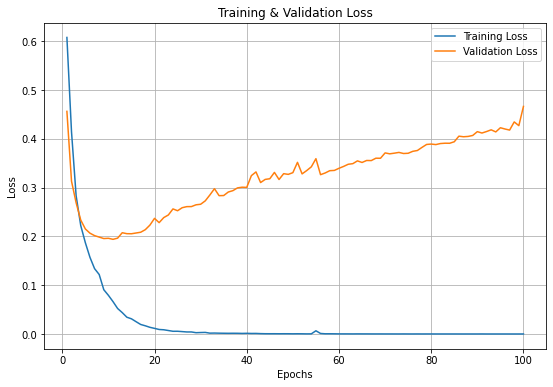

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['loss'])
plt.plot(epochs, Hist_dandc.history['val_loss'])

plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'])
plt.grid()
plt.show()

* Accuracy Visualization

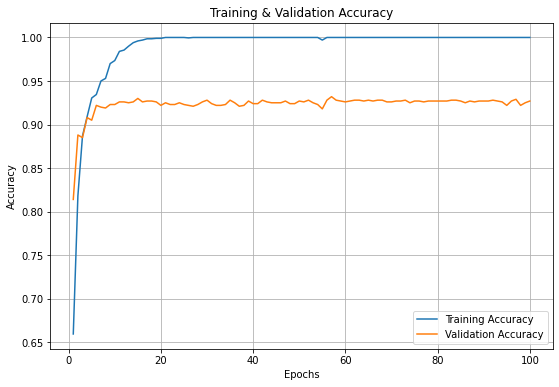

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(Hist_dandc.history['loss']) + 1)

plt.figure(figsize = (9, 6))
plt.plot(epochs, Hist_dandc.history['accuracy'])
plt.plot(epochs, Hist_dandc.history['val_accuracy'])

plt.title('Training & Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.grid()
plt.show()

> ## 5) Model Evaluate

* test_generator

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_generator = test_datagen.flow_from_directory(
                 test_dir,
                 target_size = (150, 150),
                 batch_size = 20,
                 class_mode = 'binary')

Found 1000 images belonging to 2 classes.


* Loss & Accuracy

In [ ]:
loss, accuracy = model.evaluate(test_generator,
                                steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 6s 120ms/step - loss: 0.3884 - accuracy: 0.9290
Loss = 0.38841
Accuracy = 0.92900


# IV. Model Save & Load to Google Drive

> ## 1) Google Drive Mount

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


> ## 2) Model Save

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/models/005_dogs_and_cats_fine_tuning.h5')

In [ ]:
!ls -l /content/drive/My\ Drive/Colab\ Notebooks/models

total 218537
-rw------- 1 root root     34600 Aug 31 00:45 001_Model_iris.h5
-rw------- 1 root root  41498696 Sep  1 07:55 002_dogs_and_cats_small.h5
-rw------- 1 root root  41499544 Sep  1 10:14 003_dogs_and_cats_augmentation.h5
-rw------- 1 root root 140748016 Sep  2 06:19 005_dogs_and_cats_fine_tuning.h5


> ## 3) Model Load

In [ ]:
from tensorflow.keras.models import load_model

model_google = load_model('/content/drive/My Drive/Colab Notebooks/models/005_dogs_and_cats_fine_tuning.h5')

In [ ]:
loss, accuracy = model_google.evaluate(test_generator,
                                       steps = 50)

print('Loss = {:.5f}'.format(loss))
print('Accuracy = {:.5f}'.format(accuracy))

50/50 [==============================] - 6s 120ms/step - loss: 0.3884 - accuracy: 0.9290
Loss = 0.38841
Accuracy = 0.92900


# 
# 
# 
# The End
# 
# 
# 